<a href="https://colab.research.google.com/github/SanyamSwami123/make-more-series-andrej-karpathy/blob/main/4_Activation_gradient_batchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Previous work**: In 3 series we did the MLP, we have use the 3 previous character to produce the 4 character in series.

# RNN, LSTM, GRU
- Now we will going to Use the RNN, LSTM, and GRU which is more complex.

1. **Recurrent Neural Network**:
- **Purpose**: Designed to process sequential data by maintaining a hidden state that evolves over time, allowing the network to use information from previous time steps.
  - **EXAMPLE**:
    - Regular RNNs are like building a simple tower with toy blocks where each block sticks to the one below it:
      - How It Works: Every time you add a new block, you remember the blocks below it. But if your tower gets really tall, you might forget what’s at the bottom because it's too far back.
      - Problem: If your tower is very tall, you might forget some important blocks at the bottom, which makes it hard to remember the whole thing.

2. **Gated Recurrent Units (GRUs)**:
- A type of RNN designed to address some of the limitations of standard RNNs, such as the vanishing gradient problem, while being simpler than LSTMs.
  - **EXAMPLE**
    - GRUs are like building a tower with special joints that help you remember better:
      - How It Works: Each block has smart joints that can decide to keep or forget certain parts of the tower. These joints help you remember important parts without getting too complicated.

      - Advantage: GRUs are simpler and faster. They use fewer special joints, which makes building easier and quicker.

3. **Long Short Term Memory (LSTMs):**
- Designed to capture long term dependencies and overcome the vanishing gradient problem more effectively than standard RNNs.

- LSTMs are like building an advanced tower with memory slots:

  - How It Works: This tower has separate memory slots that keep track of different parts of the tower and smart doors that decide what to keep or forget. This way, you can remember everything, even if the tower is super tall.

  - Advantage: LSTMs can remember really long towers and keep track of all the details, making them great for remembering long sequences of blocks.

**SUMMARY**:
1. **Regular RNNS**: Simple and good for small towers but forgetful with tall ones.
2. **GRUs:** Smarter joints that help remember better and are easier to use, Not use for complex towers.
3. **LSTMs:** Super advanced, works same as GRUs but use for long and complex towers.

In [ ]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# build the vocabulary of characters and mapping to/from integers
Chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(Chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?
# build dataset
def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:

    # print(w)
    context  = [0] * block_size # padded context of 0 tokens
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2])# 10%
Xte, Yte = build_dataset(words[n2:])# 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors.
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)# lookup table so each one of 27 chars we have 2 dimensions
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/(n_embd * block_size)**0.5) # we are passing this layer (3,2) thus input will  be 6 note: ( , ) here 1st dimension ie first place always takes input and 2nd place takes the no. neuron
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01 #final layer softmax
b2 = torch.randn(vocab_size, generator= g) * 0

# below are going to use for scale and shift
bngain = torch.ones((1, n_hidden)) #* 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) #* 0.1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))
# formula helps to avoid saturation, gain/ root(fenin) (5/3)/ (30**0.5) (5/3)/(n_embd * block_size)**0.5

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


tensor(0.0184) tensor(1.0028)
tensor(-0.0125) tensor(3.2056)


(array([2.01393069e-05, 1.34262046e-05, 1.34262046e-05, 2.01393069e-05,
        6.04179207e-05, 6.04179207e-05, 2.14819274e-04, 1.94679967e-04,
        4.76630264e-04, 8.25711583e-04, 1.30234185e-03, 2.36301201e-03,
        3.60493594e-03, 5.76655488e-03, 8.55920544e-03, 1.31375412e-02,
        1.99312007e-02, 2.96517729e-02, 4.20441597e-02, 5.81891708e-02,
        7.64823745e-02, 9.63397312e-02, 1.18197592e-01, 1.30724241e-01,
        1.38800103e-01, 1.31690928e-01, 1.16217227e-01, 9.41244074e-02,
        7.41126494e-02, 5.58597243e-02, 3.99966635e-02, 2.85843896e-02,
        1.93673001e-02, 1.29965661e-02, 8.74045920e-03, 5.40404735e-03,
        3.31627254e-03, 2.02064379e-03, 1.16136670e-03, 8.12285379e-04,
        4.09499241e-04, 2.95376501e-04, 2.41671683e-04, 1.40975148e-04,
        4.02786138e-05, 3.35655115e-05, 3.35655115e-05, 1.34262046e-05,
        6.71310230e-06, 6.71310230e-06]),
 array([-18.22365952, -17.47884739, -16.73403526, -15.98922314,
        -15.24441101, -14.4995

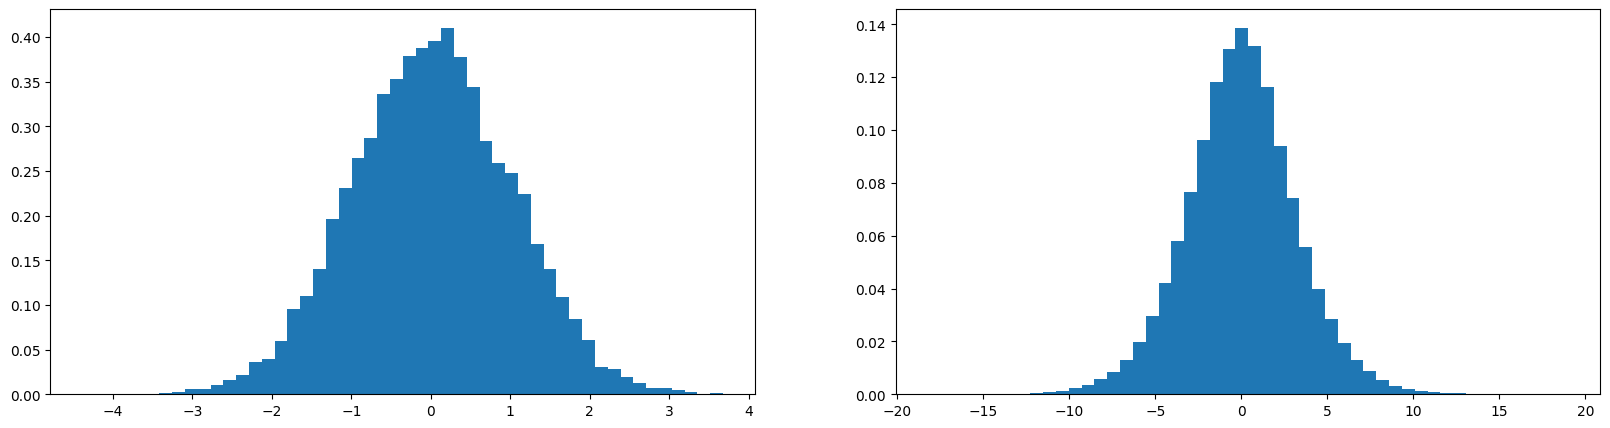

In [ ]:
'''x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50,density=True)'''

In [ ]:
# print(list(p.nelement() for p in parameters)) #size of paramtere will be sum [270, 6000, 200, 5400, 27].

[270, 6000, 200, 5400, 27]


In [ ]:
# training loop
max_steps = 200000
batch_size = 32
loss1= []

for _ in  range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix] , Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] #embed the characters into vectors # [32,3,2] emb.shape # 3 inputs with 27 character each located at 2 dimensions
  embcat = emb.view(emb.shape[0], -1) # concat the vectors

  #linear layer
  hpre_act = embcat @ W1 + b1 # hidden layer pre-activation


  #batch normalizaton/standerdization
  #----------------------------------------------------------
  # we have scale and shift (scaling batch with sum value/gain and adding bias)
  bmeani = hpre_act.mean(0, keepdim=True)
  bstdi = hpre_act.std(0, keepdim=True)
  hpre_act = bngain * (hpre_act - bmeani) / bstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bstdi
  #----------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpre_act) # hidden layer # [32,100] view is more efficient way then torch.cat(torch.unbind(emb, 1), 1)# resource:https://pytorch.org/docs/stable/generated/torch.unbind.html, as it does not store any storage
  logits = h @ W2 + b2 # output layer # [32,27]
  loss = F.cross_entropy(logits, Yb) # loss function #classification efficient loss function always use this one for Class.

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #step/update the params
  lr= 0.1 if _<100000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # find good lre you will find different and more good ways online

  # track stats
  if _ % 10000 == 0: # print every once in a while
    print(f'{_:7d}/{max_steps:7d} {loss.item():.4f}')
  loss1.append(loss.log10().item())


# print(loss.item())

      0/ 200000 3.3147
  10000/ 200000 2.1984
  20000/ 200000 2.3375
  30000/ 200000 2.4359
  40000/ 200000 2.0119
  50000/ 200000 2.2595
  60000/ 200000 2.4775
  70000/ 200000 2.1020
  80000/ 200000 2.2788
  90000/ 200000 2.1862
 100000/ 200000 1.9474
 110000/ 200000 2.3010
 120000/ 200000 1.9837
 130000/ 200000 2.4523
 140000/ 200000 2.3839
 150000/ 200000 2.1987
 160000/ 200000 1.9733
 170000/ 200000 1.8668
 180000/ 200000 1.9973
 190000/ 200000 1.8347


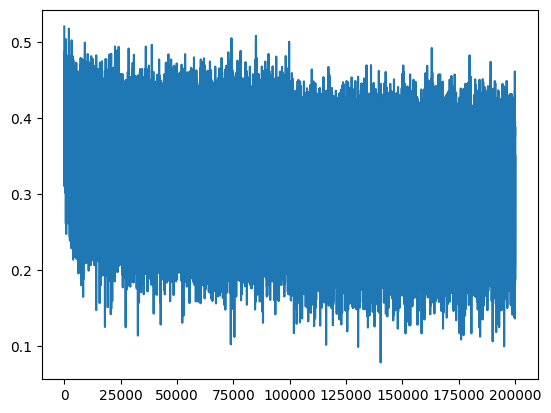

In [ ]:
plt.plot(loss1)

**calibrate the batch norm at the end of the tarining.**


In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpre_act = embcat @ W1 + b1

  # measure the mean/std over the entire training set
  bmean = hpre_act.mean(0, keepdim=True)
  bstd = hpre_act.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N,block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)

  hpre_act = embcat @ W1 + b1
  hpre_act = bngain * (hpre_act - bnmean_running) / bnstd_running + bnbias

  h = torch.tanh(hpre_act) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1,block_size, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples.
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mora.
mayanniellend.
rylla.
emmaniendra.
gradelyn.
eliah.
milophrekelson.
anarlelyn.
malqiann.
shuberg.
himier.
kindreelynn.
nicaori.
breyven.
jamelizeha.
kayjahsanyamihaan.
alynn.
june.
jolee.
ren.


# Pytorchifying the code

In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

    def __call__(self, x):
    # calculate the forward
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True, unbiased= True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

    def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


n_embd = 10 # the dimensionality of the character embedding vectors.
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)# lookup table so each one of 27 chars we have 2 dimensions
layers = [
  Linear(n_embd * block_size, n_hidde), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True